<a href="https://colab.research.google.com/github/mo-9/x-rays/blob/main/covid_19_X_rays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp  kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [3]:
!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset

 99% 1.17G/1.19G [00:08<00:00, 133MB/s]
100% 1.19G/1.19G [00:08<00:00, 152MB/s]


In [4]:
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import Adam, SGD, RMSprop

import tensorflow as tf

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
!unzip /content/coronahack-chest-xraydataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0446-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0447-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0448-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0449-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0450-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0451-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0452-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0453-0001-0002.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0453-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack

In [9]:
DATASET_DIR = '/content/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset'

In [10]:
os.listdir(DATASET_DIR)

['test', 'train']

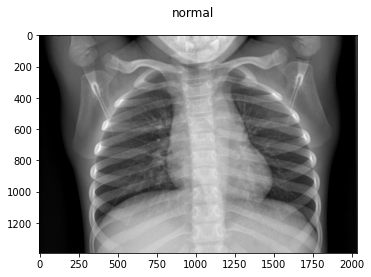

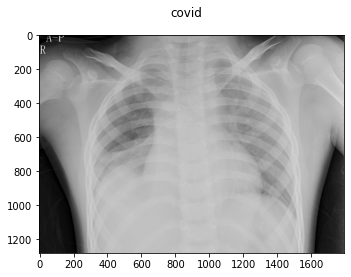

In [11]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

normal_images = []
for img_path in glob.glob(DATASET_DIR + '/test/*'):
    normal_images.append(mpimg.imread(img_path))

fig = plt.figure()
fig.suptitle('normal')
plt.imshow(normal_images[0], cmap='gray') 

covid_images = []
for img_path in glob.glob(DATASET_DIR + '/train/*'):
    covid_images.append(mpimg.imread(img_path))

fig = plt.figure()
fig.suptitle('covid')
plt.imshow(covid_images[0], cmap='gray') 

In [12]:
print(len(normal_images))
print(len(covid_images))

624
5309


In [16]:
IMG_W = 150
IMG_H = 150
CHANNELS = 3

INPUT_SHAPE = (IMG_W, IMG_H, CHANNELS)
NB_CLASSES = 2
EPOCHS = 20
BATCH_SIZE = 6
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(Conv2D(250,(3,3)))
model.add(Activation("relu"))
  
model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(AvgPool2D(2,2))
model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(AvgPool2D(2,2))

model.add(Conv2D(256,(2,2)))
model.add(Activation("relu"))
model.add(MaxPool2D(2,2))
    
model.add(Flatten())
model.add(Dense(32))
model.add(Dropout(0.25))
model.add(Dense(1))
model.add(Activation("sigmoid"))

In [17]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_8 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_9 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 64)       

In [19]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3)

train_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    DATASET_DIR, 
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle= False,
    subset='validation')

history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // BATCH_SIZE,
    epochs = EPOCHS)

Found 4154 images belonging to 2 classes.
Found 1779 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
692/692 [==============================] - 142s 139ms/step - loss: 0.4923 - accuracy: 0.9003 - val_loss: 0.3376 - val_accuracy: 0.8947
Epoch 2/20
692/692 [==============================] - 97s 140ms/step - loss: 0.4160 - accuracy: 0.8917 - val_loss: 0.3394 - val_accuracy: 0.8947
Epoch 3/20
692/692 [==============================] - 97s 141ms/step - loss: 0.4073 - accuracy: 0.8901 - val_loss: 0.3458 - val_accuracy: 0.8947
Epoch 4/20
692/692 [==============================] - 96s 139ms/step - loss: 0.3507 - accuracy: 0.8910 - val_loss: 0.3374 - val_accuracy: 0.8947
Epoch 5/20
692/692 [==============================] - 99s 143ms/step - loss: 0.3428 - accuracy: 0.8950 - val_loss: 0.3394 - val_accuracy: 0.8947
Epoch 6/20
692/692 [==============================] - 99s 143ms/step - loss: 0.3370 - accuracy: 0.8971 - val_loss: 0.3402 - val_accuracy: 0.8947
Epoch 7/20
692/692 [==============================] - 97s 140ms/step - loss: 0.3141 - accuracy: 0.9069 - val_loss: 0.3366 - val_a

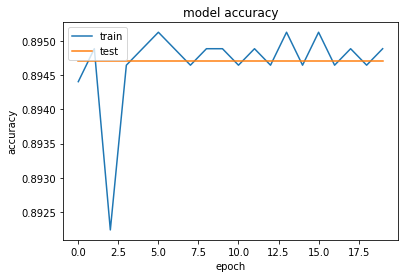

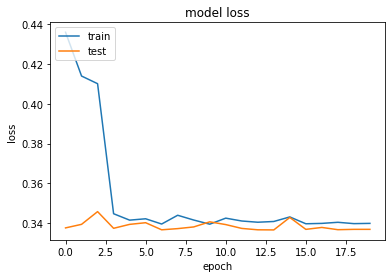

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
print("training_accuracy", history.history['accuracy'][-1])
print("validation_accuracy", history.history['val_accuracy'][-1])

training_accuracy 0.8948891162872314
validation_accuracy 0.894707202911377


In [26]:
history.history['accuracy'][-1]

0.8948891162872314

In [27]:
label = validation_generator.classes

In [28]:
label

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [31]:
pred= model.predict(validation_generator)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (validation_generator.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices]
print(predicted_class_indices)
print (labels)
print (predictions)

[0 0 0 ... 0 0 0]
{'test': 0, 'train': 1}
['test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test

In [32]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(predicted_class_indices,label)
cf

array([[ 187, 1592],
       [   0,    0]])

In [33]:
exp_series = pd.Series(label)
pred_series = pd.Series(predicted_class_indices)
pd.crosstab(exp_series, pred_series, rownames=['Actual'], colnames=['Predicted'],margins=True)

Predicted,0,All
Actual,,
0,187,187
1,1592,1592
All,1779,1779


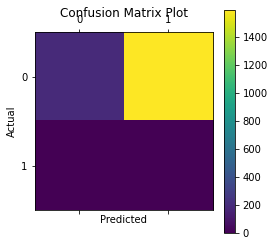

In [34]:
plt.matshow(cf)
plt.title('Confusion Matrix Plot')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show();